Found 840 images belonging to 3 classes.
Found 210 images belonging to 3 classes.
Found 117 images belonging to 3 classes.


C:\Users\kaush\AppData\Roaming\Python\Python312\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step - accuracy: 0.5473 - loss: 1.3559
Epoch 1: val_accuracy improved from -inf to 0.75238, saving model to C:\Users\kaush\Downloads\face\best_face_shape_inceptionv3_model.keras
27/27 ━━━━━━━━━━━━━━━━━━━━ 22s 481ms/step - accuracy: 0.5504 - loss: 1.3429 - val_accuracy: 0.7524 - val_loss: 0.5517
Epoch 2/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step - accuracy: 0.8100 - loss: 0.4481
Epoch 2: val_accuracy improved from 0.75238 to 0.87619, saving model to C:\Users\kaush\Downloads\face\best_face_shape_inceptionv3_model.keras
27/27 ━━━━━━━━━━━━━━━━━━━━ 9s 337ms/step - accuracy: 0.8109 - loss: 0.4472 - val_accuracy: 0.8762 - val_loss: 0.3539
Epoch 3/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - accuracy: 0.8907 - loss: 0.2944
Epoch 3: val_accuracy did not improve from 0.87619
27/27 ━━━━━━━━━━━━━━━━━━━━ 8s 290ms/step - accuracy: 0.8905 - loss: 0.2947 - val_accuracy: 0.8619 - val_loss: 0.3177
Epoch 4/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step - accu

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 217ms/step - accuracy: 0.9420 - loss: 0.1791
Test Loss: 0.16312085092067719
Test Accuracy: 0.9487179517745972
4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step  
Classification Report:
                     precision    recall  f1-score   support

Rounded_Double_Chin       0.90      1.00      0.95         9
Tapering_Triangular       1.00      0.92      0.96        77
       Thin_Angular       0.86      1.00      0.93        31

           accuracy                           0.95       117
          macro avg       0.92      0.97      0.94       117
       weighted avg       0.96      0.95      0.95       117

Confusion Matrix:
[[ 9  0  0]
 [ 1 71  5]
 [ 0  0 31]]


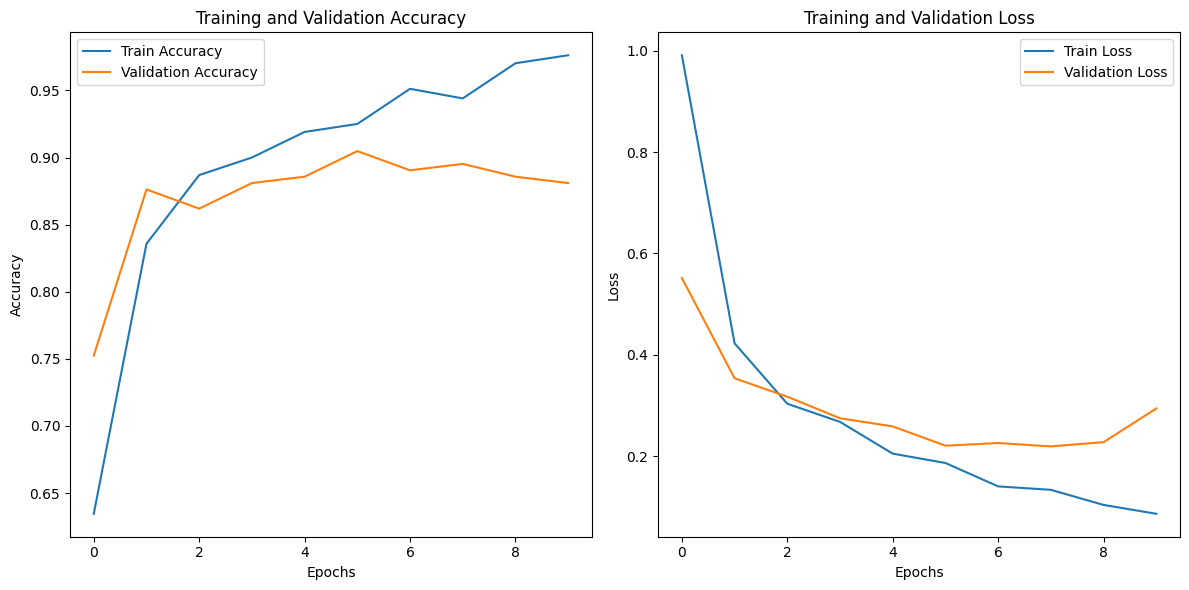

Model training, evaluation, and history saving complete.


In [1]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.callbacks import ModelCheckpoint, History
import matplotlib.pyplot as plt
import pickle

# Directories for the augmented dataset classes
augmented_dataset_dir = r'C:\Users\kaush\Downloads\face\augmented_dataset'
rounded_double_chin_dir = os.path.join(augmented_dataset_dir, 'Rounded_Double_Chin')
tapering_triangular_dir = os.path.join(augmented_dataset_dir, 'Tapering_Triangular')
thin_angular_dir = os.path.join(augmented_dataset_dir, 'Thin_Angular')

# Parameters
img_size = (128, 128)
batch_size = 32

# Data generators for augmented dataset (training and validation split)
datagen = ImageDataGenerator(rescale=1.0/255, validation_split=0.2)

train_generator = datagen.flow_from_directory(
    augmented_dataset_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

validation_generator = datagen.flow_from_directory(
    augmented_dataset_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

# Data generator for testing with unaugmented dataset
unaugmented_test_dir = r'C:\Users\kaush\Downloads\face\dataset'
test_datagen = ImageDataGenerator(rescale=1.0/255)
test_generator = test_datagen.flow_from_directory(
    unaugmented_test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# Model creation using InceptionV3
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output_layer = Dense(3, activation='softmax')(x)  # 3 output classes

model = Model(inputs=base_model.input, outputs=output_layer)

# Compile the model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Define the checkpoint to save the best InceptionV3 model with .keras extension
checkpoint_path = r'C:\Users\kaush\Downloads\face\best_face_shape_inceptionv3_model.keras'
model_checkpoint = ModelCheckpoint(
    filepath=checkpoint_path,
    monitor='val_accuracy',  # Monitor validation accuracy
    save_best_only=True,     # Save only the best model
    mode='max',
    verbose=1
)

# Define History to save model training history
history = History()

# Train the model with the checkpoint and history callback
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=10,
    callbacks=[model_checkpoint, history]
)

# Save the final model with .h5 extension after training
model.save(r'C:\Users\kaush\Downloads\face\face_shape_inceptionv3_model_final.h5')

# Evaluate the model on the unaugmented test set
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Generate classification report and confusion matrix
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes

print("Classification Report:")
print(classification_report(y_true, y_pred_classes, target_names=test_generator.class_indices.keys()))

print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred_classes))

# Save the training history to a file
history_path = r'C:\Users\kaush\Downloads\face\training_history_inceptionv3.pkl'
with open(history_path, 'wb') as f:
    pickle.dump(history.history, f)

# Plot training & validation accuracy
plt.figure(figsize=(12, 6))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

print("Model training, evaluation, and history saving complete.")


In [2]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Calculate overall precision, recall, and f1-score
precision = precision_score(y_true, y_pred_classes, average='weighted')
recall = recall_score(y_true, y_pred_classes, average='weighted')
f1 = f1_score(y_true, y_pred_classes, average='weighted')

# Print the results
print(f"Overall Precision = {precision * 100:.2f}")
print(f"Overall Recall = {recall * 100:.2f}")
print(f"Overall F1-score = {f1 * 100:.2f}")


Overall Precision = 95.55
Overall Recall = 94.87
Overall F1-score = 94.95
